Calibrate MPU and output adjusted log.

In [22]:
import matplotlib.pylab as pylab
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 12, 12

def from_space_separated(file):
    log = []
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            parts = line.split(' ')
            try:
                # ax,ay,az,gx,gy,gz,dt_s,y,p,r
                ax = parts[0]
                ay = parts[1]
                az = parts[2]
                gx = parts[3]
                gy = parts[4]
                gz = parts[5]
                dt = parts[6]
                y = parts[7]
                p = parts[8]
                r = parts[9]
                log.append(np.array([ax, ay, az, gx, gy, gz, y, p, r, dt]).astype(np.float))
            except Exception as e:
                print('lol, err: {}'.format(e))
    return np.array(log)

log = from_space_separated('calibration_and_pose.txt')
log_time = np.cumsum(log[:, 9])

Use first six seconds to estimate accelerometer noise levels.

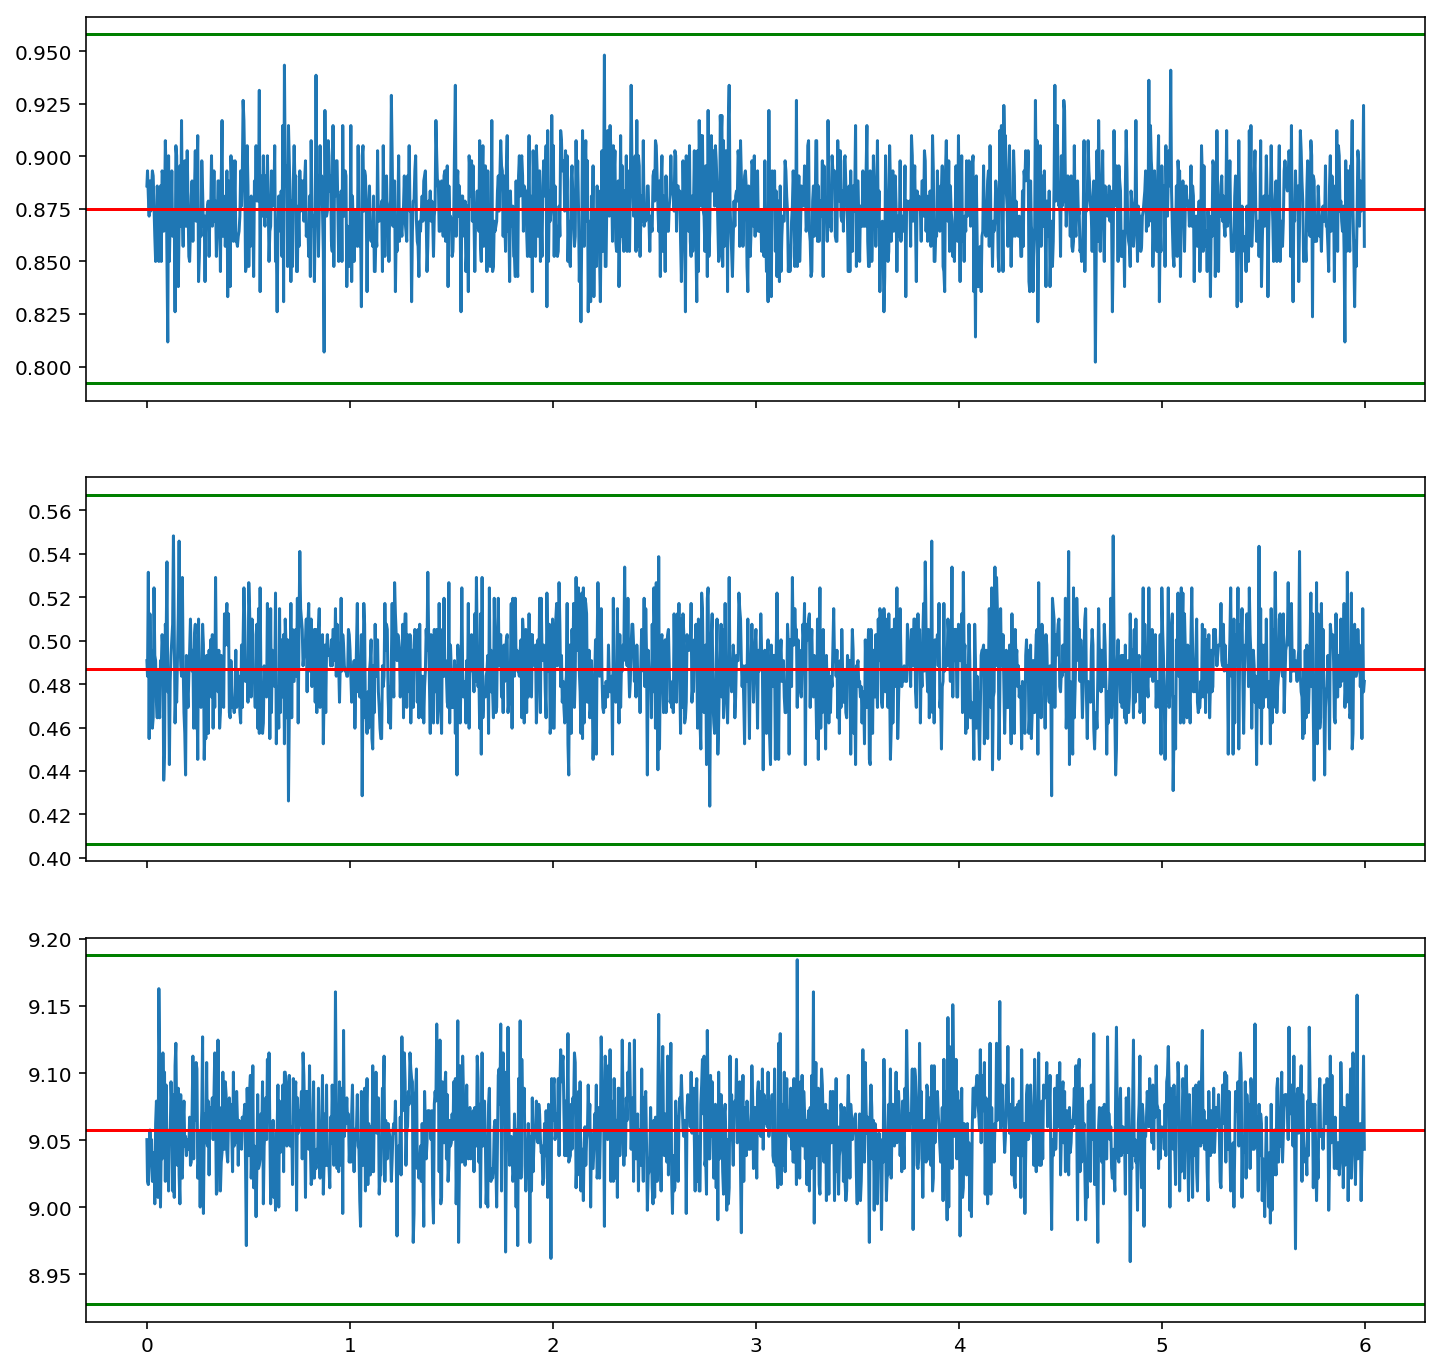

In [23]:
def plot_multi(log, cols, time=None):
    f, axarr = plt.subplots(len(cols), sharex=True)
    for i, c in enumerate(cols):
        if not time is None:
            axarr[i].plot(time, log[:, c])
        else:
            axarr[i].plot(log[:, c])
    return f, axarr

noise_time = 6
noise_axes = [0, 1, 2]
sigma = 4
noise_log = log[log_time < noise_time, :]
_, axarr = plot_multi(noise_log, noise_axes, time=log_time[log_time < noise_time])

stdevs = []
means = []
for i, c in enumerate(noise_axes):
    std = np.std(noise_log[:, c])
    mean = np.mean(noise_log[:, c])
    axarr[i].axhline(mean, c = 'red')
    axarr[i].axhline(mean + sigma * std, c = 'green')
    axarr[i].axhline(mean - sigma * std, c = 'green')
    stdevs.append(std)
    means.append(mean)

Given noise estimates find still ranges. To do so first convert raw accelerations to the angle-to-ground.

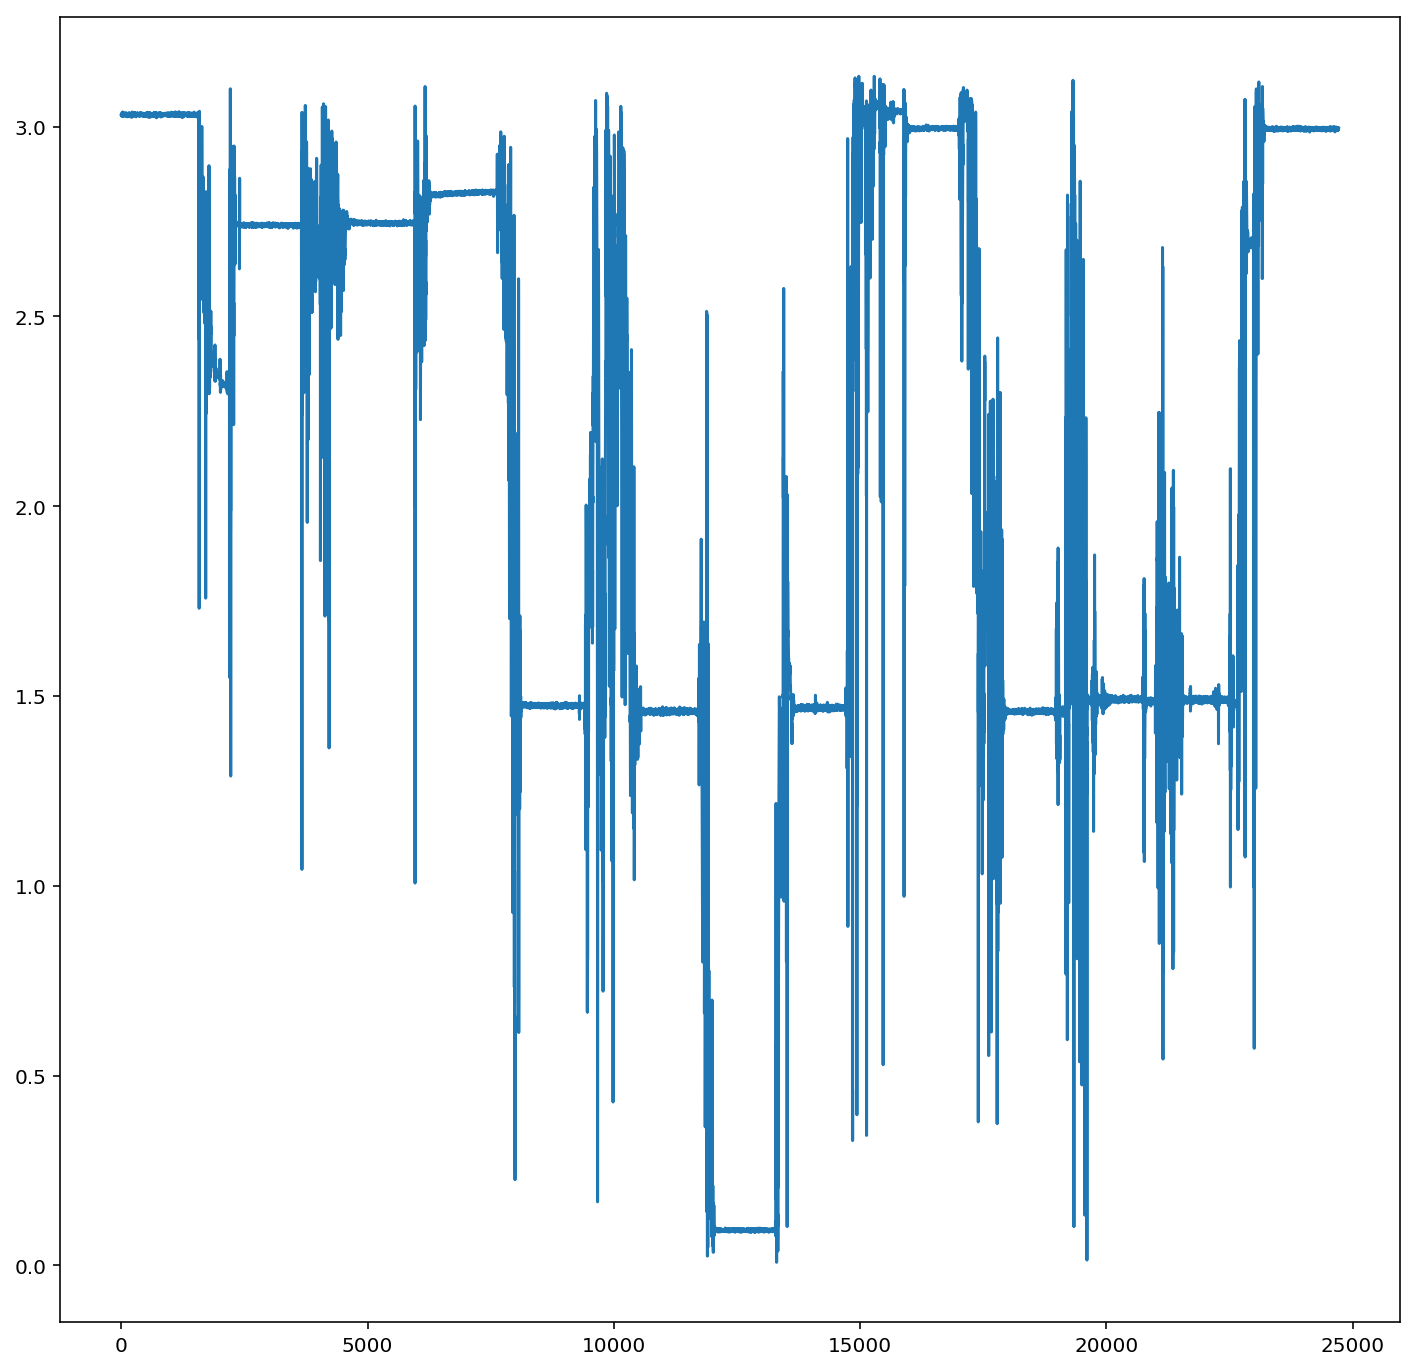

In [24]:
def normal_angle(v):
    v1 = v / np.linalg.norm(v)
    v2 = np.array([0.0, 0.0, -1.0])
    return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

axs = np.array([log[:, 0], log[:, 1], log[:, 2]])
angs = np.apply_along_axis(normal_angle, 0, axs)
plt.plot(angs)

To account for different orientations use differences instead of raw values.

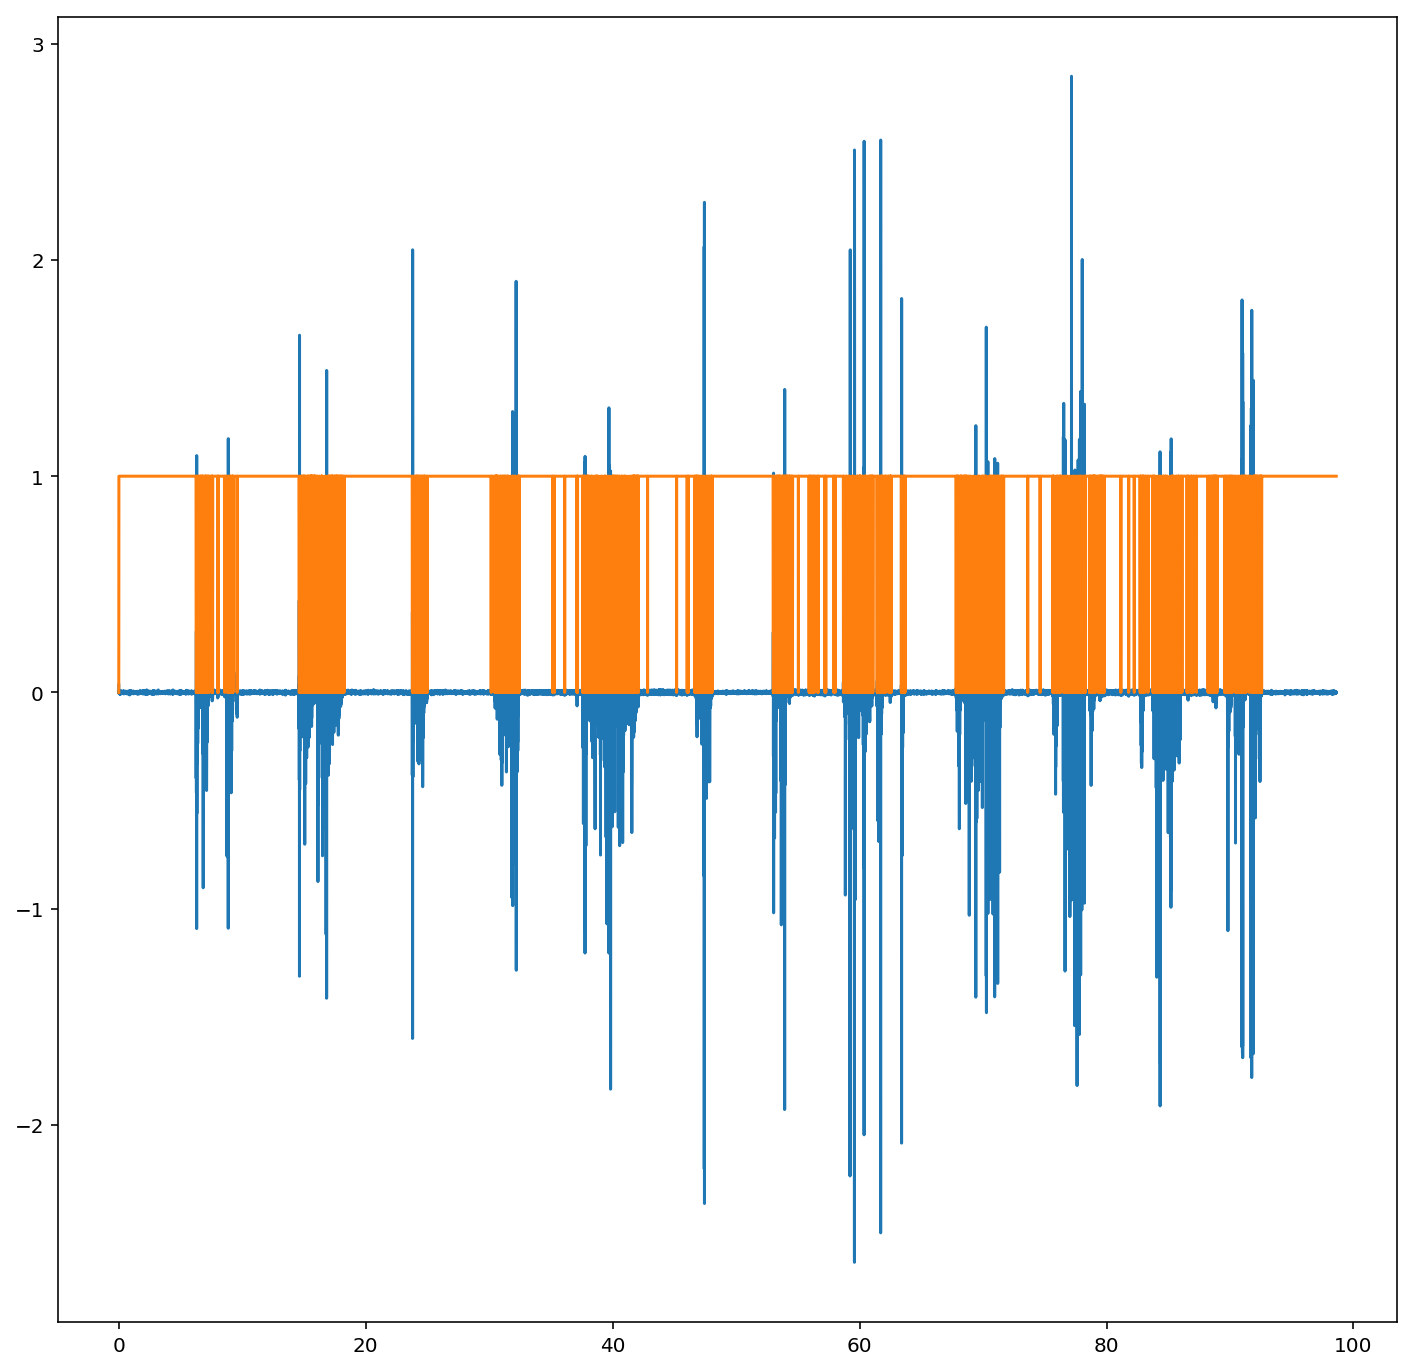

In [25]:
ang_diffs = angs - np.roll(angs, 1)
noise_ang = ang_diffs[log_time < noise_time,]
std = np.std(noise_ang)
stills = np.abs(ang_diffs) < sigma * std

plt.plot(log_time, ang_diffs)
plt.plot(log_time, stills)

Leave only ones that are long enought and take first six as calibration values.

In [26]:
inside = False
start_idx = 0
still_min_time = 2
calibration_stills = []

for i, s in enumerate(stills):
    if s:
        if not inside:
            inside = True
            start_idx = i
    else:
        if inside:
            inside = False
            if log_time[i] - log_time[start_idx] > still_min_time:
                calibration_stills.append((start_idx, i, log_time[start_idx]))

calibration_axs = [(log[i[0]:i[1], 0], log[i[0]:i[1], 1], log[i[0]:i[1], 2]) for i in calibration_stills]

calibrations = []
for i in range(6):
    calibrations.append((np.mean(calibration_axs[i][0]),
                        np.mean(calibration_axs[i][1]),
                        np.mean(calibration_axs[i][2])))
print(calibrations)

[(0.875197354745223, 0.48686533045859876, 9.057376290764331), (1.06336922849162, 3.4870432513168392, 8.585191416999203), (3.495075821330441, 1.0723723025958063, 8.748127968185106), (0.6312382884722222, -2.7221954893518516, 8.509621664351851), (2.9333838679355786, 10.08773471522694, -1.0073568826207906), (-8.619112069727892, -0.6591537665816326, -0.96982881292517)]


For now I just put those into won2010 manually and obtained the following:
* { gain: 0.9991745, bias: 1.1136332 }
* { gain: 0.9974563, bias: 0.47671285 }
* { gain: 0.99826837, bias: -0.73273396 }

Time to apply those and see what's happen!

In [27]:
ax_gain = 0.9991745
ax_bias = 1.1136332
ay_gain = 0.9974563
ay_bias = 0.47671285
az_gain = 0.99826837
az_bias = -0.73273396

adj_ax = np.array((log[:, 0] - ax_bias) / ax_gain)
adj_ay = np.array((log[:, 1] - ay_bias) / ay_gain)
adj_az = np.array((log[:, 2] - az_bias) / az_gain)

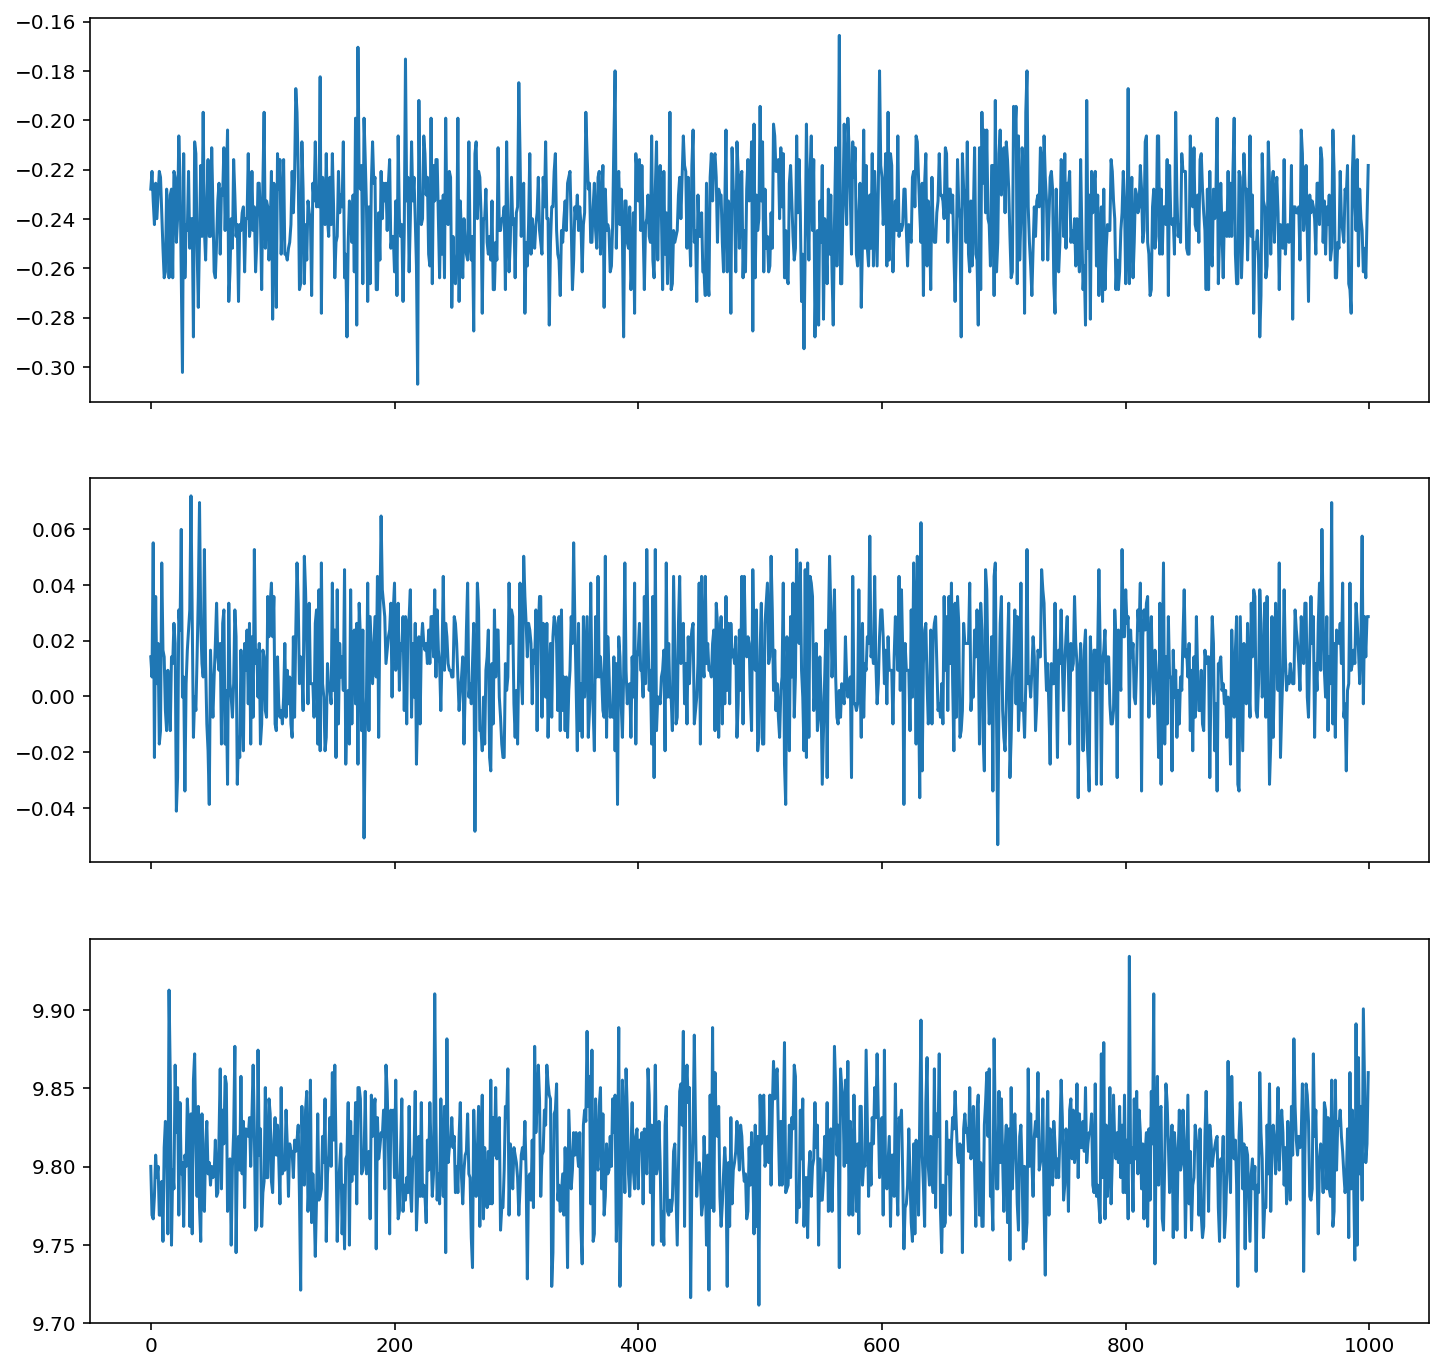

In [28]:
test = np.vstack([adj_ax, adj_ay, adj_az]).transpose()
_, _ = plot_multi(test[0:1000], [0, 1, 2])#, time=log_time)


In [29]:
log_out = np.vstack([adj_ax, adj_ay, adj_az, log[:, 3], log[:, 4], log[:, 5], log[:, 6], log[:, 7], log[:, 8], log[:, 9]]).transpose()

with open('calibrated_pose.txt', 'w', encoding='latin-1') as f:
    for line in log_out:
        f.write("{} {} {} {} {} {} {} {} {} {}\r\n".format(*line))

And DCMIMU on the calibrated data gives us:

In [30]:
dcm_y = []
dcm_p = []
dcm_r = []

with open('calibrated_out.txt', 'r', encoding='latin-1') as f:
    for line in f:
        parts = line.split(', ')
        dcm_y.append(float(parts[0]))
        dcm_p.append(float(parts[1]))
        dcm_r.append(float(parts[2]))

dcm_y = np.array(dcm_y)
dcm_p = np.array(dcm_p)
dcm_r = np.array(dcm_r)

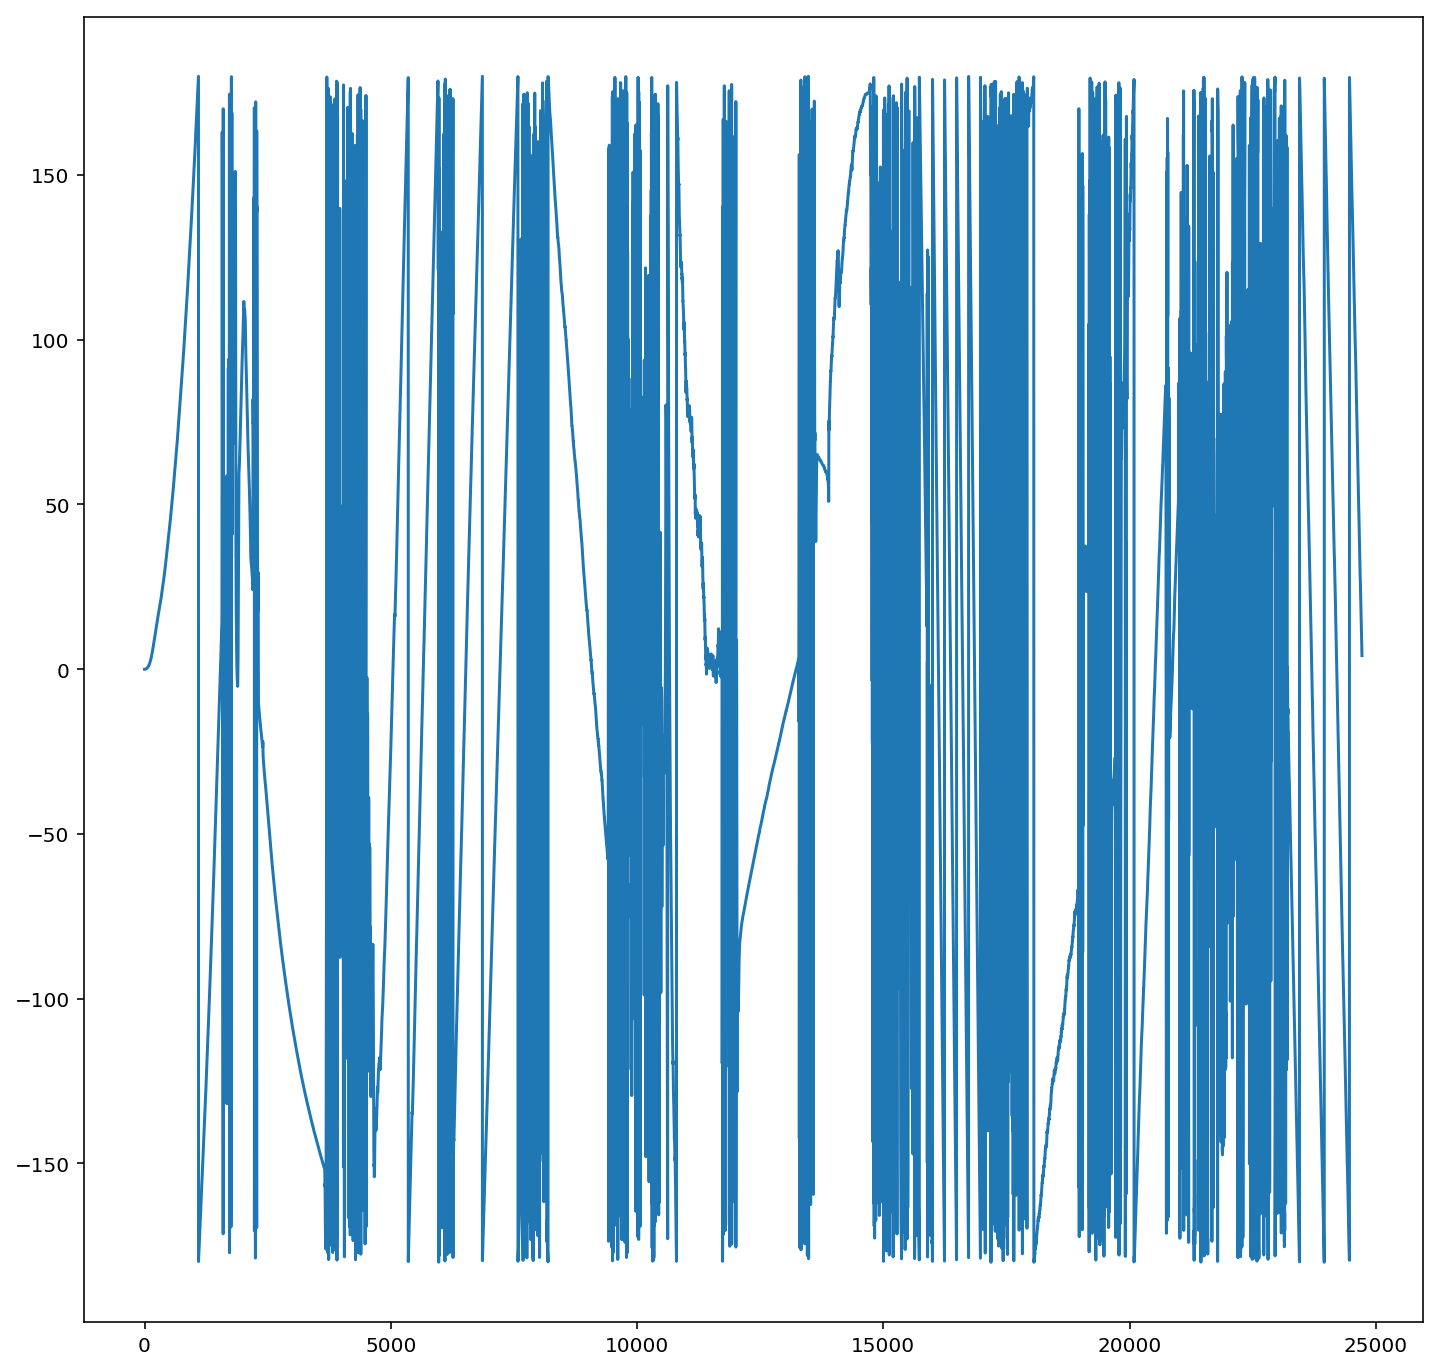

In [31]:
plt.plot(np.degrees(dcm_y))

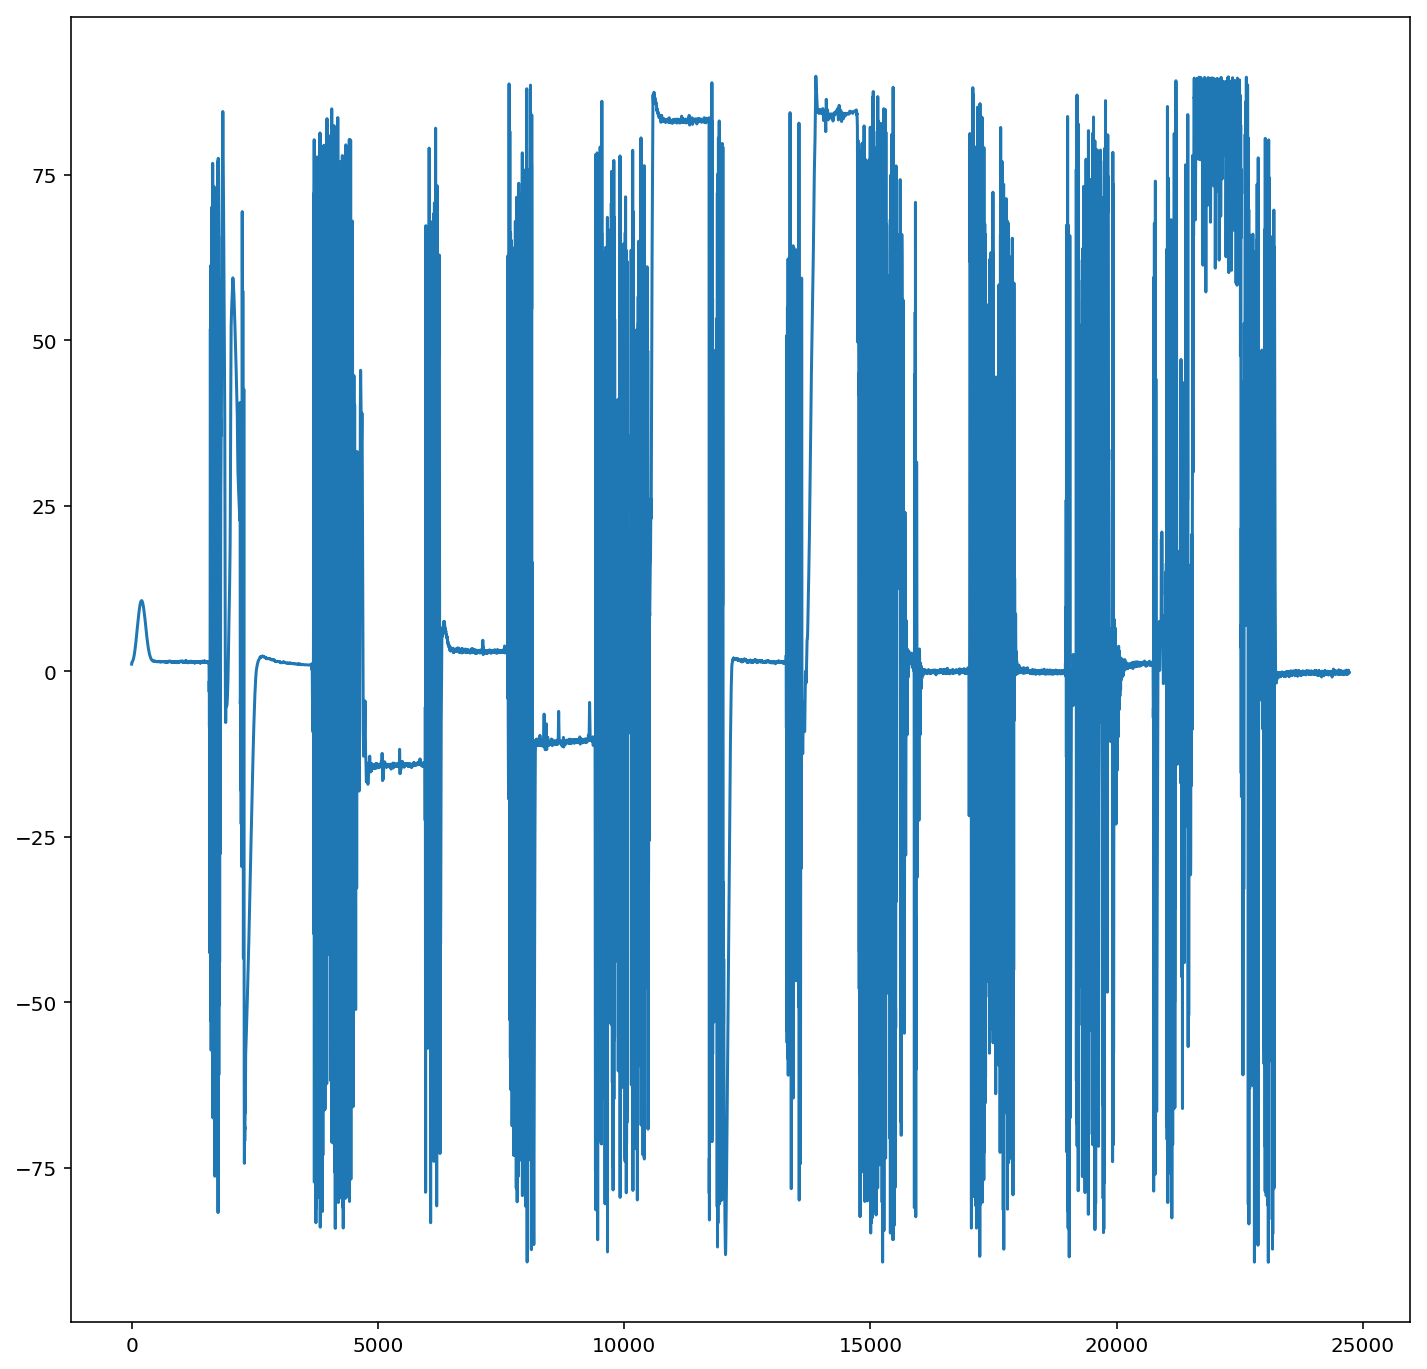

In [32]:
plt.plot(np.degrees(dcm_p))

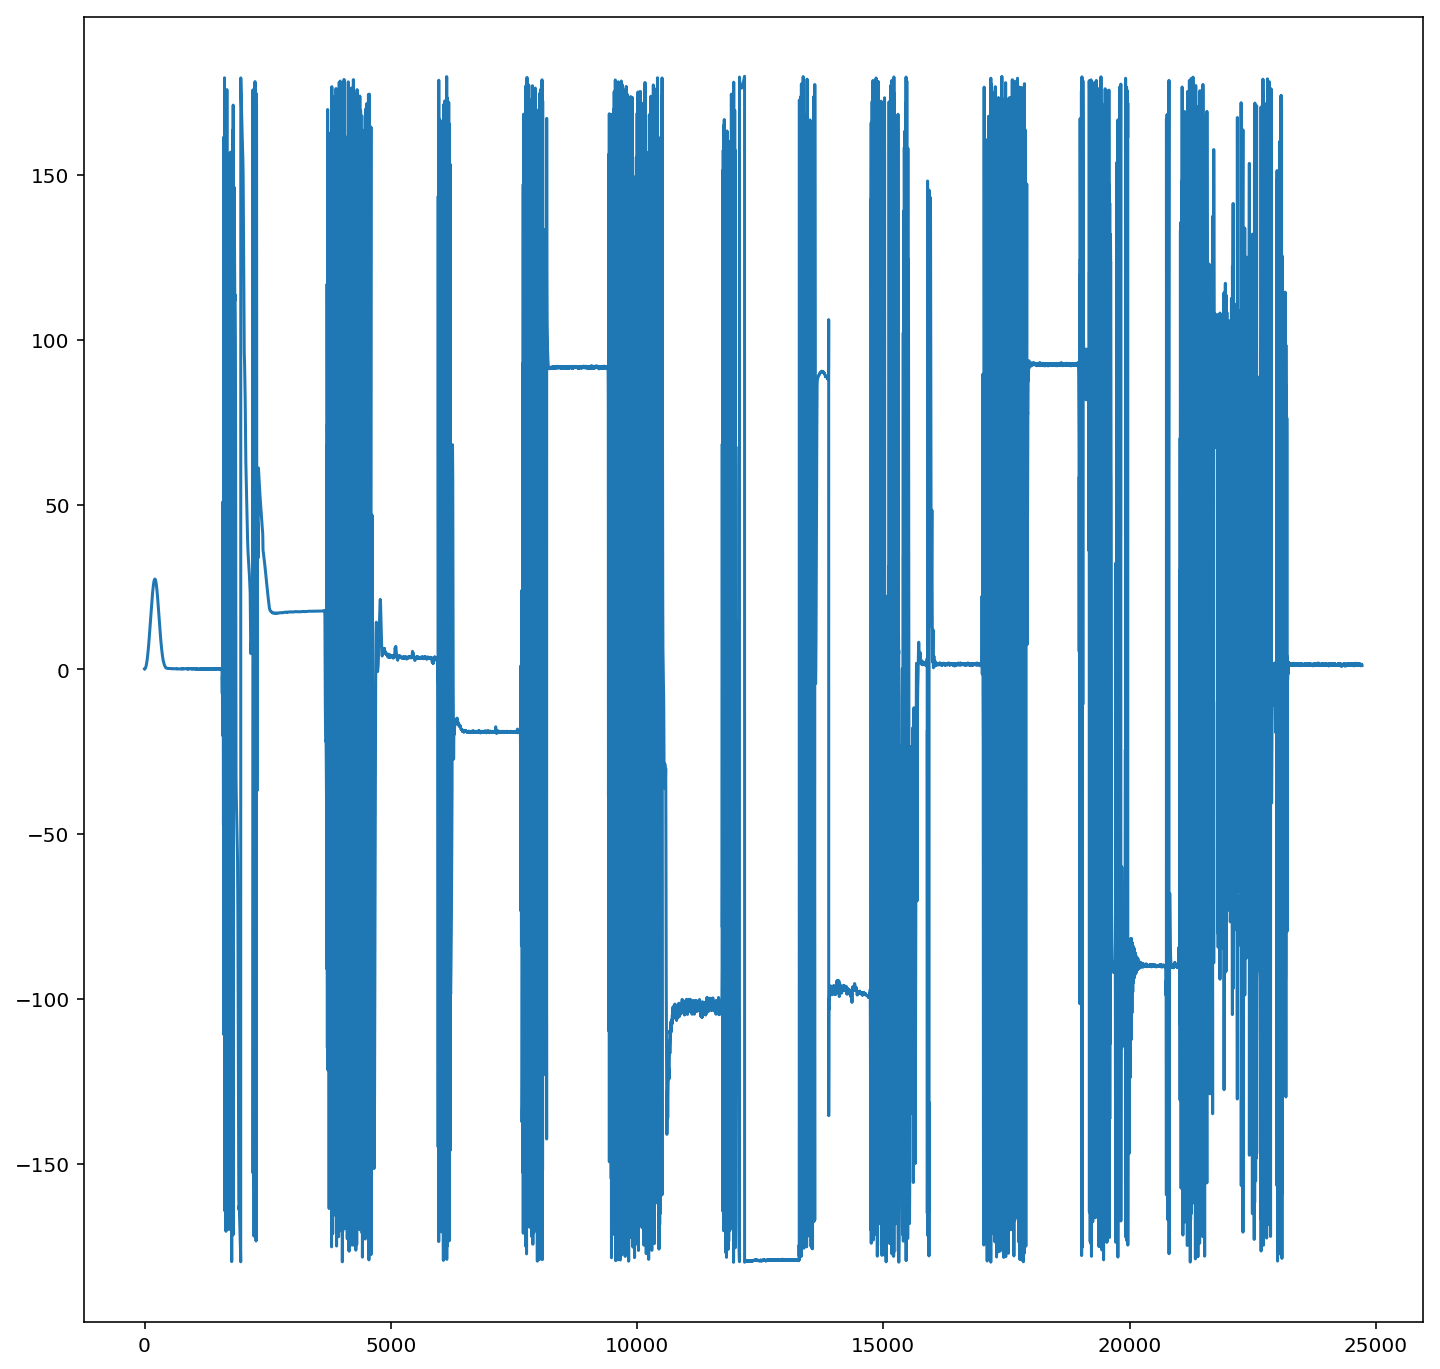

In [33]:
plt.plot(np.degrees(dcm_r))